In [1]:
!pip install polars
!pip install graphviz

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import polars as pl
import theano
import seaborn as sns
!pip install pyarrow
from statsmodels.stats.power import tt_ind_solve_power
%matplotlib inline

from src.simulations import *
from src.plotting import *
from src.modeling import *
#Convert effect sizes from r to Cohen's D 
r_to_d = lambda r: r/np.sqrt(1-r**2)

In [2]:
prior={'s':1,
    't':1,
    'b':1}
df = pl.read_csv('./data/rpp_data.csv',ignore_errors=True).filter(
    (pl.col('T_pval_USE..R.').is_not_null()) & 
    (pl.col('T_pval_USE..O.').is_not_null()) &
    (pl.col('T_r..R.').is_not_null()) &
    (pl.col('T_r..O.').is_not_null()) 
).with_columns([
    (r_to_d(pl.col('T_r..R.').cast(float))).alias("d_r"),
    (r_to_d(pl.col('T_r..O.').cast(float))).alias("d_o"),
    pl.col('N (R)').cast(int).alias("n_r"),
    pl.col('N (O)').cast(int).alias("n_o"),
]).select([
    'd_o','d_r','n_o','n_r'
]).filter((pl.col("n_o") < 2000))
df['direction'] = np.random.choice(np.array([-1,1]), df.shape[0])       
with pm.Model() as m_1:
    #Hyperpriors
    sigma = pm.Exponential("sigma", prior['s'])
    tau = pm.Exponential("tau", prior['t'])

    bias_sigma =pm.Exponential("bias_sigma", prior['b'])

    #Priors
    noise_r = pm.Normal('noise_o', 0, sigma=sigma,shape=df.shape[0])
    noise_o = pm.Normal('noise_r',0, sigma=sigma,shape=df.shape[0])
    signal = pm.Normal('signal',0,tau,shape=df.shape[0])
    bias = pm.HalfNormal('bias',bias_sigma)

    #Epsilon
    s_o=1/pm.math.sqrt(df.n_o)
    s_r=1/pm.math.sqrt(df.n_r)

    #Model
    d_o = pm.Normal("d_o", mu=noise_o + signal + bias * df.direction, 
                    sigma=s_o, observed=df.direction*df.d_o)
    d_r = pm.Normal("d_r", mu=noise_r + signal, 
                    sigma=s_r, observed=df.direction*df.d_r) 

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1561: UserWarning: setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1345: UserWarning: accessing series as Attribute of a DataFrame is deprecated
  warnings.warn("accessing series as Attribute of a DataFrame is deprecated")
/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1345: UserWarning: accessing series as Attribute of a DataFrame is deprecated
  warnings.warn("accessing series as Attribute of a DataFrame is deprecated")
/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1345: UserWarning: accessing series as Attribute of a DataFrame is deprecated
  warnings.warn("accessing series as Attribute of a DataFrame is deprecated")
/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1345: UserWarning: accessing series as Attribute of a DataFrame is deprecated
  warning

<h1>Psychology RPP</h1>

In [3]:
#Load RPP Data, randomize direction. 
df_psych = pl.read_csv('./data/rpp_data.csv',ignore_errors=True).filter(
    (pl.col('T_pval_USE..R.').is_not_null()) & 
    (pl.col('T_pval_USE..O.').is_not_null()) &
    (pl.col('T_r..R.').is_not_null()) &
    (pl.col('T_r..O.').is_not_null()) 
).with_columns([
    (r_to_d(pl.col('T_r..R.').cast(float))).alias("d_r"),
    (r_to_d(pl.col('T_r..O.').cast(float))).alias("d_o"),
    pl.col('N (R)').cast(int).alias("n_r"),
    pl.col('N (O)').cast(int).alias("n_o"),
]).select([
    'd_o','d_r','n_o','n_r'
])
df_psych.head(5)
df_psych['direction'] = np.random.choice(np.array([-1,1]), df_psych.shape[0])

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1561: UserWarning: setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column
  warnings.warn(


In [4]:
from scipy import stats

In [5]:
idata_psych,trace_psych,prior_psych, ppc_psych = sample_publishing_model(df_psych,
                                                                        prior={'s':1,
                                                                        't':1,
                                                                        'b':1})

/home/joebak/Projects/ReplicationSurveys/src/modeling.py:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias, signal, noise_r, noise_o, bias_sigma, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 126 seconds.
The number of effective samples is smaller than 25% for some parameters.


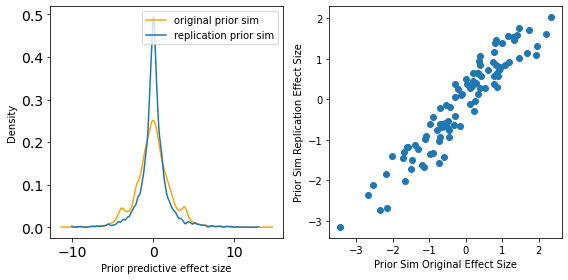

In [6]:
plot_prior_checks(prior_psych, './output/figures/SIPriorRPP.png')

In [7]:
make_summary_table(idata_psych, './output/tables/psych_posterior.tex')

/home/joebak/Projects/ReplicationSurveys/src/modeling.py:70: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(save_loc)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.127,0.018,0.094,0.160,0.001,0.001,547.0,1228.0,1.01
tau,0.367,0.035,0.298,0.431,0.001,0.000,2574.0,2812.0,1.00


/home/joebak/Projects/ReplicationSurveys/src/plotting.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


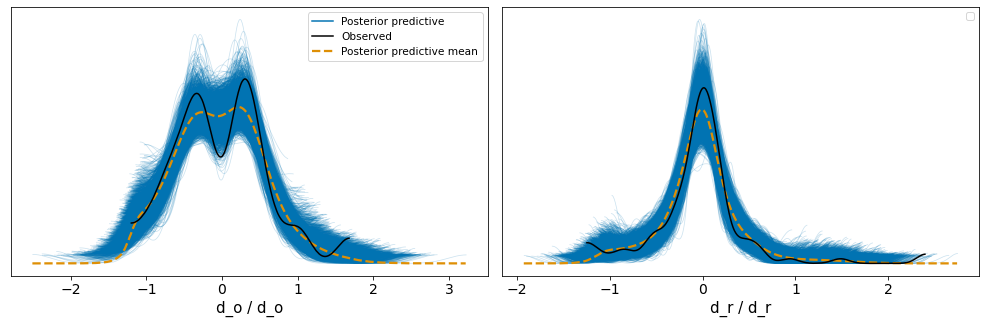

In [8]:
plot_posterior_distribution(idata_psych,save_loc='./output/figures/PosteriorDistributionRPP.png')

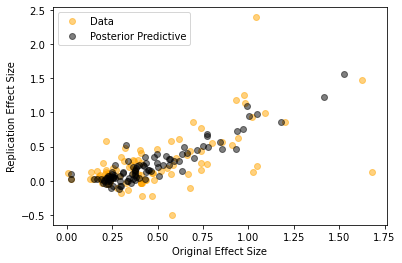

In [9]:
plot_posterior_predictive(df_psych, ppc_psych, './output/figures/PosteriorPredictiveRPP.png')

In [10]:
out_psych = simulate(idata_psych,save_loc='./output/psych_sims.csv')
out_psych.head()

publication_rate,replication_rate,type_s_error,published_es,actual_es,reversals,replication_es,N,j,alpha
f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
0.011534,0.0335,0.0023,0.351543,0.340062,0.0022,0.339861,10,500,0.005
0.021312,0.048325,0.004792,0.369889,0.357247,0.0032,0.356457,10,500,0.01
0.0854,0.077392,0.025398,0.3936,0.375722,0.006887,0.375542,10,500,0.05
0.151736,0.079857,0.053235,0.381009,0.364,0.008102,0.364271,10,500,0.1
0.268448,0.081532,0.113987,0.361858,0.348147,0.0103,0.347844,10,500,0.2


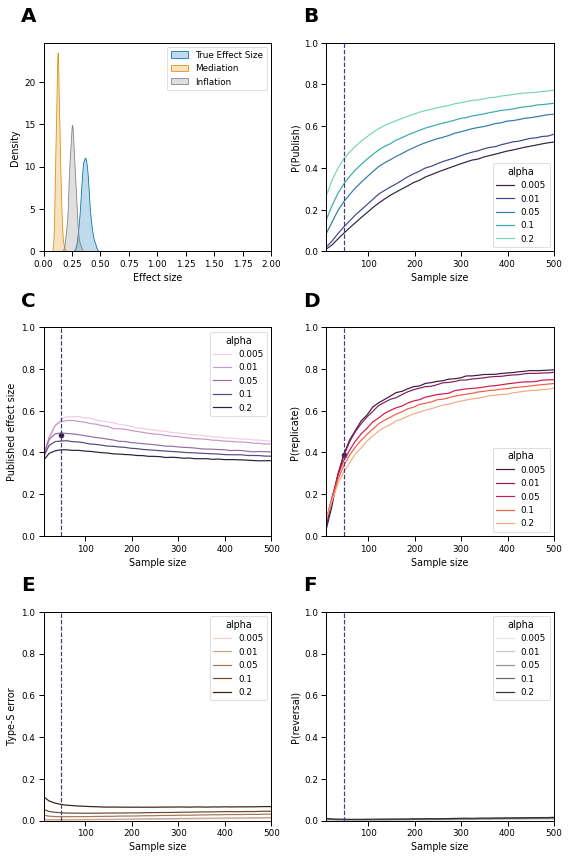

In [11]:
plot_sim_figure(idata_psych, out_psych.to_pandas(), df_psych,save_loc='./output/figures/Figure4.png')

In [71]:
stemp

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,idx
0,signal[63],-0.867,0.109,-1.084,-0.677,0.002,0.001,3263.0,3000.0,1.0,0
1,signal[84],-0.840,0.103,-1.036,-0.648,0.002,0.001,2730.0,2778.0,1.0,1
2,signal[8],-0.835,0.150,-1.107,-0.551,0.002,0.002,4306.0,3087.0,1.0,2
3,signal[62],-0.802,0.114,-1.015,-0.586,0.002,0.001,3626.0,3190.0,1.0,3
4,signal[22],-0.668,0.198,-1.024,-0.281,0.003,0.002,5846.0,2931.0,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...
92,signal[6],0.537,0.135,0.270,0.780,0.002,0.002,3614.0,2731.0,1.0,92
93,signal[73],0.547,0.150,0.267,0.832,0.002,0.002,5170.0,3132.0,1.0,93
94,signal[25],0.696,0.155,0.410,0.992,0.002,0.001,5635.0,3640.0,1.0,94
95,signal[70],1.128,0.180,0.810,1.472,0.003,0.002,4582.0,2810.0,1.0,95


Text(0, 0.5, 'Effect size')

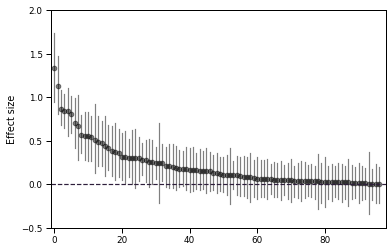

In [100]:

def plot(row):
    sign = np.sign(row['mean'])
    plt.scatter(row['idx'], sign*row['mean'],color='k',alpha=.5)
    plt.plot([row['idx'], row['idx']], 
             [sign*row['hdi_3%'], sign*row['hdi_97%']],color='k',alpha=.5)
    
stemp = az.summary(idata_psych['posterior']['signal']).sort_values(by='mean',key=abs,ascending=False).reset_index()
stemp['idx'] = np.arange(stemp.shape[0])
stemp.apply(plot,axis=1)

plt.ylim(-.5,2)
plt.plot([-1, 98], [0, 0], ls='--')
plt.xlim([-1,98])
plt.ylabel('Effect size')


In [ ]:
az.summary(idata_psych['posterior']['signal'])[negative_lower & postive_higher]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
signal[0],-0.257,0.150,-0.521,0.032,0.002,0.002,5642.0,3324.0,1.0
signal[2],0.018,0.148,-0.257,0.291,0.002,0.002,5691.0,2889.0,1.0
signal[3],-0.013,0.097,-0.185,0.175,0.001,0.002,5157.0,2893.0,1.0
signal[4],-0.167,0.133,-0.426,0.065,0.002,0.001,5556.0,3053.0,1.0
signal[7],-0.148,0.139,-0.417,0.107,0.002,0.002,5545.0,3194.0,1.0
...,...,...,...,...,...,...,...,...,...
signal[89],0.064,0.116,-0.148,0.276,0.002,0.002,4832.0,3125.0,1.0
signal[91],0.166,0.136,-0.092,0.417,0.002,0.002,5230.0,3523.0,1.0
signal[92],-0.014,0.122,-0.241,0.216,0.002,0.002,4912.0,3086.0,1.0
signal[94],0.211,0.124,-0.036,0.427,0.002,0.001,5539.0,3108.0,1.0


<h1>Economics RPP</h1>

<h2>Data import</h2>

In [12]:
df_econ = pl.read_csv(('./data/Camerer2016_raw.csv')).filter(
    (pl.col('eorig').is_not_null()) & 
    (pl.col('erep').is_not_null()) &
    (pl.col('nrep_act').is_not_null()) &
    (pl.col('norig').is_not_null()) 
).with_columns([
    (r_to_d(pl.col('erep').cast(float))).alias("d_r"),
    (r_to_d(pl.col('eorig').cast(float))).alias("d_o"),
    pl.col('nrep_act').cast(int).alias("n_r"),
    pl.col('norig').cast(int).alias("n_o"),
]).select([
    'd_o','d_r','n_o','n_r'
])
df_econ['direction'] = np.random.choice([-1,1], size=df_econ.shape[0])

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1561: UserWarning: setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column
  warnings.warn(


In [13]:
idata_econ,trace_econ,prior_econ, ppc_econ = sample_publishing_model(df_econ,prior={'s':.5,
                                                                        't':.5,
                                                                        'b':.5})

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1345: UserWarning: accessing series as Attribute of a DataFrame is deprecated
  warnings.warn("accessing series as Attribute of a DataFrame is deprecated")
/home/joebak/Projects/ReplicationSurveys/src/modeling.py:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias, signal, noise_r, noise_o, bias_sigma, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


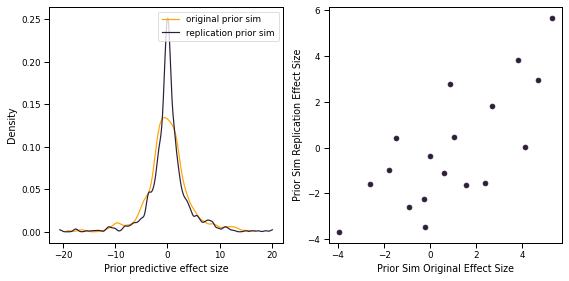

In [14]:
plot_prior_checks(prior_econ, 
                  './output/figures/SIPriorEcon.png')

In [15]:
make_summary_table(idata_econ, 
                   './output/tables/econ_posterior.tex')

/home/joebak/Projects/ReplicationSurveys/src/modeling.py:70: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(save_loc)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.372,0.078,0.234,0.521,0.004,0.003,351.0,1456.0,1.01
tau,0.266,0.139,0.012,0.478,0.012,0.008,135.0,225.0,1.02


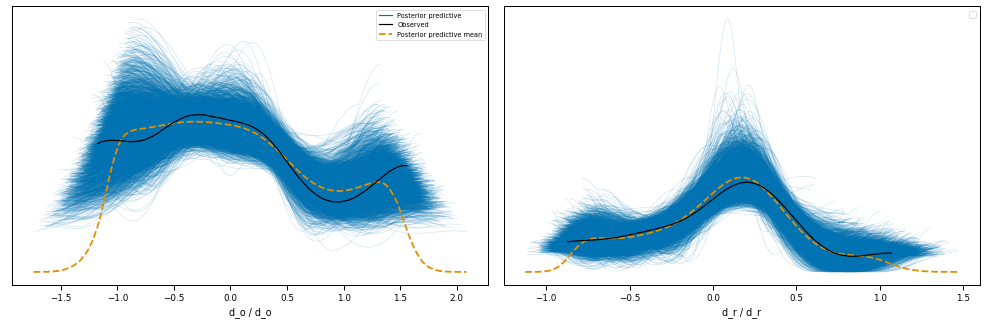

In [16]:
plot_posterior_distribution(idata_econ,
                            save_loc='./output/figures/PosteriorDistributionEcon.png')

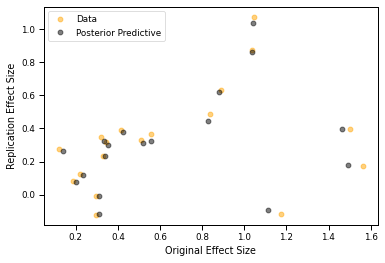

In [17]:
plot_posterior_predictive(df_econ, 
                          ppc_econ, 
                          './output/figures/PosteriorPredictiveEcon.png')

In [18]:
prob_sig = np.mean(
    np.array(
    pl.read_csv(
        ('./data/Camerer2016_raw.csv')
                            
    )['porig'])<.05)
out_econ = simulate(idata_psych,
                    save_loc='./output/econ_sims.csv',
                    prob_sig=prob_sig)
out_econ.head()

publication_rate,replication_rate,type_s_error,published_es,actual_es,reversals,replication_es,N,j,alpha
f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
0.011495,0.032749,0.002357,0.345032,0.338017,0.001852,0.338319,10,500,0.005
0.021393,0.047263,0.004784,0.375166,0.361278,0.002492,0.359952,10,500,0.01
0.085,0.076547,0.025512,0.394639,0.375016,0.0074,0.376407,10,500,0.05
0.151866,0.079887,0.053394,0.382326,0.3647,0.010108,0.363819,10,500,0.1
0.268552,0.080217,0.113854,0.362273,0.349336,0.009895,0.349858,10,500,0.2


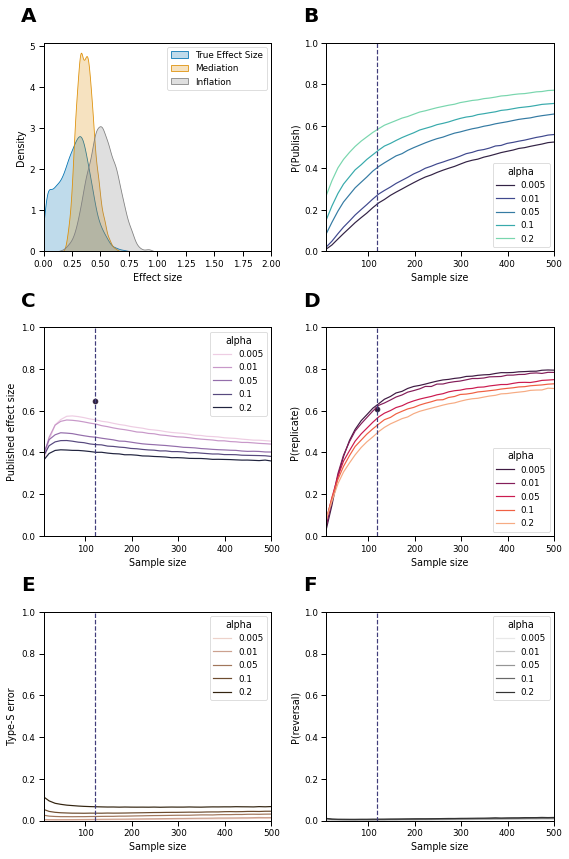

In [19]:
plot_sim_figure(idata_econ, 
                out_econ.to_pandas(), 
                df_econ,
                plot_medians=True,
                rep=.61,
                save_loc='./output/figures/Figure5.png')

<h2>Sampling</h2>

<h1>Preclinical cancer biology</h1>

In [20]:
temp = pl.read_csv('./data/RP_CB Final Analysis - Effect level data.csv',ignore_errors=True)
for column in temp.columns:
    print(column)

Paper #
Experiment #
Effect #
Internal replication #
Effect description
Expected difference based on the original paper?
Observed difference in replication?
Original sample size
Replication sample size
Was a statistical test reported in the original paper?
What statistical test was reported?
Statistical test applied to original data
Original test statistic type
Original test statistic value
Original df1
Original df2
Original p value
Replication statistical test
Replication test statistic type
Replication test statistic value
Replication df1
Replication df2
Replication p value
Was original data representative?
Original point difference (for representative data)
Replication raw difference (if original reported representative data)
Replication raw difference type (mean or median)
Replication raw diference standard error
Replication raw difference lower CI
Replication raw difference upper CI
Effect size type
Original effect size
Original standard error
Original lower CI
Original upper CI
R

In [21]:
#Load RPP Data, randomize direction. 
df_biol = pl.read_csv('./data/RP_CB Final Analysis - Effect level data.csv',ignore_errors=True).with_columns([
    (pl.col('Replication effect size (SMD)').cast(float, strict=False)).alias("d_r"),
    (pl.col('Replication sample size').cast(int)).alias("n_r"),
    pl.col('Original effect size (SMD)').cast(float,strict=False).alias("d_o"),
    pl.col('Original sample size').cast(int,strict=False).alias("n_o"),
]).select([
    'd_o','d_r','n_o','n_r'
]).filter(
    (pl.col('d_o').is_not_null()) & 
    (pl.col('d_r').is_not_null()) &
    (pl.col('n_o').is_not_null()) &
    (pl.col('n_r').is_not_null()) 
)
df_biol.head(5)
df_biol['direction'] = np.random.choice(np.array([-1,1]), df_biol.shape[0])
df_biol.head()

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1561: UserWarning: setting a DataFrame by indexing is deprecated; Consider using DataFrame.with_column
  warnings.warn(


d_o,d_r,n_o,n_r,direction
f64,f64,i64,i64,i64
15.55022,0.2433831,6,10,1
6.153975,1.728561,6,10,1
23.24239,1.832289,6,10,-1
7.692164,1.588906,6,10,1
17.08841,0.1037272,6,10,-1


In [22]:
idata_biol,trace_biol,prior_biol, ppc_biol = sample_publishing_model(df_biol,prior={'s':.5,
                                                                        't':.5,
                                                                        'b':.5})

/opt/conda/lib/python3.9/site-packages/polars/internals/frame.py:1345: UserWarning: accessing series as Attribute of a DataFrame is deprecated
  warnings.warn("accessing series as Attribute of a DataFrame is deprecated")
/home/joebak/Projects/ReplicationSurveys/src/modeling.py:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias, signal, noise_r, noise_o, bias_sigma, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 230 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8514830560955391, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


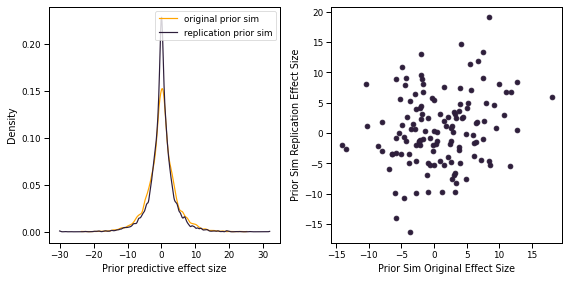

In [23]:
plot_prior_checks(prior_biol, './output/figures/SIPriorBiol.png')

In [24]:
make_summary_table(idata_biol, './output/tables/biol_posterior.tex')

/home/joebak/Projects/ReplicationSurveys/src/modeling.py:70: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(save_loc)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,7.674,0.414,6.913,8.472,0.027,0.019,242.0,707.0,1.02
tau,2.034,0.887,0.494,3.723,0.131,0.093,40.0,25.0,1.11


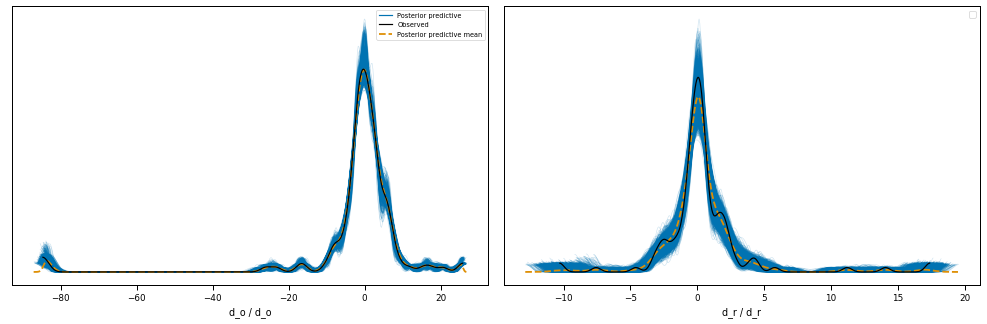

In [25]:
plot_posterior_distribution(idata_biol,
                            save_loc='./output/figures/PosteriorDistributionBiol.png')

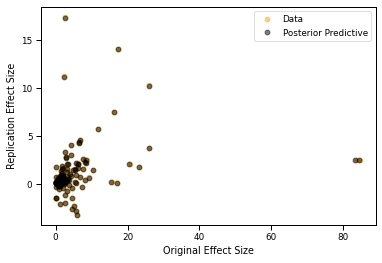

In [26]:
plot_posterior_predictive(df_biol, 
                          ppc_biol, 
                          './output/figures/PosteriorPredictiveBiol.png')

In [27]:
out_biol = simulate(idata_biol,save_loc='./output/biol_sims.csv',prob_sig=136/158)
out_biol.head()

publication_rate,replication_rate,type_s_error,published_es,actual_es,reversals,replication_es,N,j,alpha
f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
0.768784,0.507326,0.318726,2.087345,1.658245,0.345242,1.647329,10,500,0.005
0.797782,0.507922,0.332548,2.019256,1.657436,0.344468,1.6848,10,500,0.01
0.860461,0.508847,0.361982,1.883992,1.649755,0.345934,1.647871,10,500,0.05
0.886651,0.509285,0.3766,1.820796,1.624464,0.348169,1.623482,10,500,0.1
0.914564,0.509458,0.391367,1.753306,1.622742,0.3485,1.625646,10,500,0.2


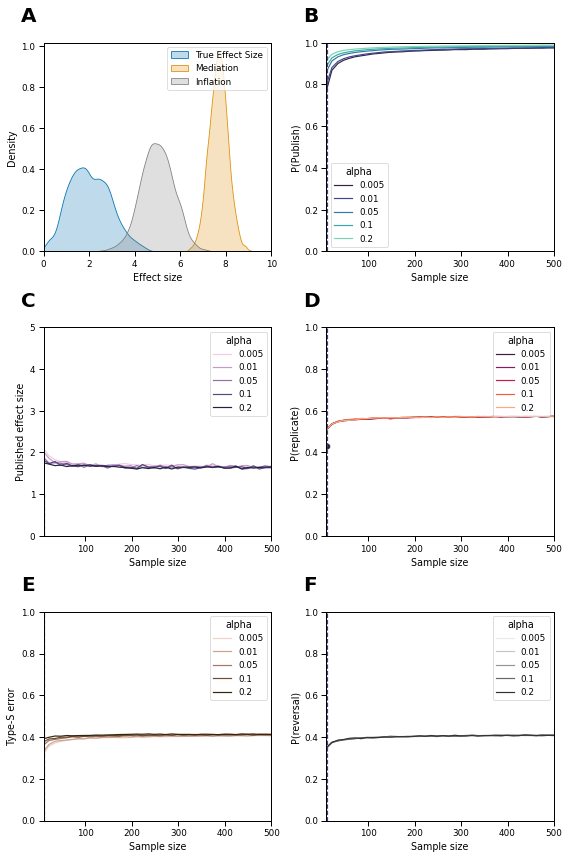

In [28]:
axs = plot_sim_figure(idata_biol, out_biol.to_pandas(), df_biol,
                save_loc='./output/figures/Figure6.png',plot_medians=True,rep=.43, max_effect=10)
